# 1 Image Processing

In [62]:
# import os
# import random
# import shutil

# # 原始数据集根文件夹
# dataset_root = '/local/data1/honzh073/data/patient_level'

# # 目标数据集文件夹
# target_dataset_folder = '/local/data1/honzh073/data/patient_level_dataset'

# # 创建目标数据集文件夹
# os.makedirs(target_dataset_folder, exist_ok=True)

# # AFF和NFF文件夹
# fracture_types = ['AFF', 'NFF']

# # 分割数据集的比例
# train_ratio = 0.7
# val_ratio = 0.2
# test_ratio = 0.1

# # 遍历AFF和NFF文件夹
# for fracture_type in fracture_types:
#     source_folder = os.path.join(dataset_root, fracture_type)
#     patients = os.listdir(source_folder)
    
#     # 随机打乱患者顺序
#     random.shuffle(patients)
    
#     # 划分数据集
#     total_patients = len(patients)
#     train_end = int(total_patients * train_ratio)
#     val_end = train_end + int(total_patients * val_ratio)
    
#     train_patients = patients[:train_end]
#     val_patients = patients[train_end:val_end]
#     test_patients = patients[val_end:]
    
#     # 复制图片到相应的数据集文件夹
#     for patient_id in train_patients:
#         source_path = os.path.join(source_folder, patient_id)
#         target_path = os.path.join(target_dataset_folder, 'train', fracture_type, patient_id)
#         shutil.copytree(source_path, target_path)
    
#     for patient_id in val_patients:
#         source_path = os.path.join(source_folder, patient_id)
#         target_path = os.path.join(target_dataset_folder, 'val', fracture_type, patient_id)
#         shutil.copytree(source_path, target_path)
    
#     for patient_id in test_patients:
#         source_path = os.path.join(source_folder, patient_id)
#         target_path = os.path.join(target_dataset_folder, 'test', fracture_type, patient_id)
#         shutil.copytree(source_path, target_path)

# print("Dataset split completed.")


In [63]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from torch.optim import lr_scheduler
import torchvision.models as models

# ----------------------------------------------------------------------------------------------
# Augmentation
# Define data augmentation transforms
# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),  # Randomly rotate the image up to 30 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Adjust color
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=.5),  # Random affine transformation
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=.5),  # Randomly apply perspective transformations
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image to RGB
])

test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image to RGB
])

# Define the data loaders
train_dataset = ImageFolder(root='/local/data1/honzh073/data/patient_level_dataset/train', transform=train_transform)
validation_dataset = ImageFolder(root='/local/data1/honzh073/data/patient_level_dataset/val', transform=test_transform)
test_dataset = ImageFolder(root='/local/data1/honzh073/data/patient_level_dataset/test', transform=test_transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# ----------------------------------------------------------------------------------------------
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda:0")  # Use GPU 0
else:
    print("CUDA is not available.")
    device = torch.device("cpu")
# ----------------------------------------------------------------------------------------------
print('done!')


CUDA is available!
done!


# Plot Images

Image 1 Path: /local/data1/honzh073/data/patient_level_dataset/val/NFF/patient_AYQYEXUPLG/patient_AYQYEXUPLG_hospital_12_NFF_image_3.png
Image 2 Path: /local/data1/honzh073/data/patient_level_dataset/val/NFF/patient_PSIAFNAOHS/patient_PSIAFNAOHS_hospital_33_NFF_image_1.png
Image 3 Path: /local/data1/honzh073/data/patient_level_dataset/val/AFF/patient_QCFIKCSVST/patient_QCFIKCSVST_hospital_18_AFF_image_2.png
Image 4 Path: /local/data1/honzh073/data/patient_level_dataset/val/NFF/patient_WLCXHPRFYR/patient_WLCXHPRFYR_hospital_100_NFF_image_6.png
Image 5 Path: /local/data1/honzh073/data/patient_level_dataset/val/NFF/patient_RCGHEIUHUO/patient_RCGHEIUHUO_hospital_100_NFF_image_4.png


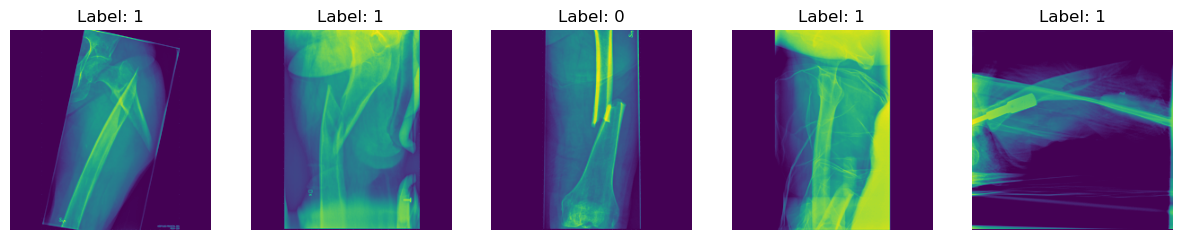

In [64]:
# Get some random indices from the validation dataset
random_indices = np.random.choice(len(validation_dataset), 5, replace=False)

# Print image file paths
for i, idx in enumerate(random_indices):
    filename = validation_dataset.samples[idx][0]  # Get the filename
    print(f"Image {i + 1} Path: {filename}")

# Plot images (transformed) with truncated names
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    image, label = validation_dataset[idx]  # Use validation_dataset directly
    filename = validation_dataset.samples[idx][0]  # Get the filename
    truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
    plt.subplot(1, 5, i + 1)
    plt.title(f"Label: {label}")
    # plt.imshow(image[0], cmap='gray')  # Single-channel (grayscale)
    plt.imshow(image[0])  # Single-channel (grayscale)

    plt.axis('off')
plt.show()


# Class weights of Training Dataset

In [65]:
# ---------------------------------------------------------------------------------
import os

def count_number(path_folder):
    # AFF和NFF文件夹路径
    aff_folder = os.path.join(path_folder, 'AFF')
    nff_folder = os.path.join(path_folder, 'NFF')

    # 统计AFF和NFF文件夹中的图片数量
    aff_image_count = sum(len(files) for _, _, files in os.walk(aff_folder))
    nff_image_count = sum(len(files) for _, _, files in os.walk(nff_folder))
    
    return aff_image_count, nff_image_count

print('Total:')
path_folder = '/local/data1/honzh073/data/patient_level'
total_aff_num, total_nff_num = count_number(path_folder)
print('aff number:', total_aff_num, '; nff number:', total_nff_num)

print('Train:')
path_folder = '/local/data1/honzh073/data/patient_level_dataset/train'
aff_num, nff_num = count_number(path_folder)
print('aff number:', aff_num, '; nff number:', nff_num)
print('%:', round(aff_num / total_aff_num * 100, 0), '; %:', round(nff_num / total_nff_num * 100, 0))

print('Val:')
path_folder = '/local/data1/honzh073/data/patient_level_dataset/val'
aff_num, nff_num = count_number(path_folder)
print('aff number:', aff_num, '; nff number:', nff_num)
print('%:', round(aff_num / total_aff_num * 100, 0), '; %:', round(nff_num / total_nff_num * 100, 0))

print('Test:')
path_folder = '/local/data1/honzh073/data/patient_level_dataset/test'
aff_num, nff_num = count_number(path_folder)
print('aff number:', aff_num, '; nff number:', nff_num)
print('%:', round(aff_num / total_aff_num * 100, 0), '; %:', round(nff_num / total_nff_num * 100, 0))

# aff and nff numbers in training dataset
train_aff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 AFF
train_nff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 NFF

# ---------------------------------------------------------------------------------
# Calculate class weights
n_aff_train = train_aff_count
n_nff_train = train_nff_count

class_weight_aff = 1 / (2 * (n_aff_train / (n_aff_train + n_nff_train)))
class_weight_nff = 1 / (2 * (n_nff_train / (n_aff_train + n_nff_train)))

print(f"Class Weight for AFF (0): {class_weight_aff:.4f}")
print(f"Class Weight for NFF (1): {class_weight_nff:.4f}")


Total:
aff number: 868 ; nff number: 3474
Train:
aff number: 609 ; nff number: 2435
%: 70.0 ; %: 70.0
Val:
aff number: 178 ; nff number: 688
%: 21.0 ; %: 20.0
Test:
aff number: 81 ; nff number: 351
%: 9.0 ; %: 10.0


Class Weight for AFF (0): 2.4992
Class Weight for NFF (1): 0.6251


# ResNet152
## lr = 0.0001, step_size = 10, and gamma = 0.1

In [75]:
from torchvision.models import resnet152, ResNet152_Weights
import torch

# pretrained model location
torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Settings
lr = 0.0001
step_size = 10
gamma = 0.1

num_epochs = 50

# ResNet152
model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
model.fc = nn.Linear(2048, 2)  # output layer classes number = dataset classes number
model = model.to(device)

# Loss function
class_weights = torch.Tensor([class_weight_aff, class_weight_nff]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training (loss and accuracy)
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    
    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0
    
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()
    
    # validation accuracy and loss
    validation_accuracy = 100 * correct_validation / total_validation
    validation_loss /= len(validation_loader)
    
    train_losses.append(loss.item())
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Acc: {validation_accuracy:.2f}%")
    
    scheduler.step()  # Step the learning rate scheduler

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend() 

plt.show()




Epoch 1/50, Train Loss: 0.3748, Validation Loss: 0.5050, Train Acc: 65.28%, Validation Acc: 78.29%
Epoch 2/50, Train Loss: 0.1009, Validation Loss: 0.2569, Train Acc: 82.00%, Validation Acc: 90.53%
Epoch 3/50, Train Loss: 0.1396, Validation Loss: 0.2856, Train Acc: 88.73%, Validation Acc: 87.53%
Epoch 4/50, Train Loss: 0.0850, Validation Loss: 0.2425, Train Acc: 91.16%, Validation Acc: 91.11%
Epoch 5/50, Train Loss: 0.1245, Validation Loss: 0.2233, Train Acc: 92.25%, Validation Acc: 91.57%
Epoch 6/50, Train Loss: 0.0717, Validation Loss: 0.2244, Train Acc: 93.33%, Validation Acc: 91.92%
Epoch 7/50, Train Loss: 0.0212, Validation Loss: 0.2568, Train Acc: 95.24%, Validation Acc: 91.69%
Epoch 8/50, Train Loss: 0.0624, Validation Loss: 0.2352, Train Acc: 95.34%, Validation Acc: 91.11%
Epoch 9/50, Train Loss: 0.0755, Validation Loss: 0.2811, Train Acc: 95.57%, Validation Acc: 90.18%
Epoch 10/50, Train Loss: 0.0520, Validation Loss: 0.2237, Train Acc: 95.93%, Validation Acc: 93.19%
Epoch 11/

KeyboardInterrupt: 

: 

In [67]:
# Define the data loaders
# test_dataset = ImageFolder(root='/local/data1/honzh073/data/hospital_33', transform=transform)

# batch_size = 64

# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

from sklearn.metrics import confusion_matrix, classification_report

# Test dataset performance
model.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


original_classes = train_loader.dataset.classes

# confusion matrix
with torch.no_grad():
    all_predictions = []
    all_labels = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)

# Precision、Recall、F1 Score
classification_rep = classification_report(all_labels, all_predictions, target_names=original_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)


Test Loss: 0.2301, Test Acc: 89.81%
Confusion Matrix:
[[ 75   6]
 [ 38 313]]
Classification Report:
              precision    recall  f1-score   support

         AFF       0.66      0.93      0.77        81
         NFF       0.98      0.89      0.93       351

    accuracy                           0.90       432
   macro avg       0.82      0.91      0.85       432
weighted avg       0.92      0.90      0.90       432



# Save model

In [68]:
# Save the trained VGG model
torch.save(model.state_dict(), '/local/data1/honzh073/saved_model/patient_level_resnet152.pth')


In [69]:
def eva(test_loader):
        
    # Test dataset performance
    model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

    from sklearn.metrics import confusion_matrix, classification_report

    original_classes = train_loader.dataset.classes

    # confusion matrix
    with torch.no_grad():
        all_predictions = []
        all_labels = []

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Precision、Recall、F1 Score
    classification_rep = classification_report(all_labels, all_predictions, target_names=original_classes)

    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)


In [70]:
# 在所有image上的表现
images = ImageFolder(root='/local/data1/honzh073/data/8bit_by_types', transform=test_transform)

image_loader = DataLoader(images, batch_size=batch_size, shuffle=False, pin_memory=True)

eva(image_loader)

Test Loss: 0.1497, Test Acc: 94.29%
Confusion Matrix:
[[ 838   30]
 [ 218 3256]]
Classification Report:
              precision    recall  f1-score   support

         AFF       0.79      0.97      0.87       868
         NFF       0.99      0.94      0.96      3474

    accuracy                           0.94      4342
   macro avg       0.89      0.95      0.92      4342
weighted avg       0.95      0.94      0.94      4342



# Clean GPU memory

In [71]:
torch.cuda.empty_cache()


# VGG19

In [72]:
# from torchvision.models import vgg19, VGG19_Weights

# # Settings
# lr = 0.0001
# step_size = 10
# gamma = 0.1

# # Move class weights to the selected device
# class_weights = [class_weight_aff, class_weight_nff]
# class_weights = torch.Tensor(class_weights).to(device)

# # VGG19
# model = models.vgg19(weights=VGG19_Weights.DEFAULT)  # Load the pre-trained VGG19 model
# model.classifier[6] = nn.Linear(4096, 2)  # Modify the last fully connected layer
# model = model.to(device)

# # Loss function
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# criterion = criterion.to(device)

# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# # Training and validation
# train_losses = []
# validation_losses = []
# train_accuracies = []
# validation_accuracies = []

# num_epochs = 50
# for epoch in range(num_epochs):
#     model.train()
#     correct_train = 0
#     total_train = 0

#     for images, labels in train_loader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         _, predicted = torch.max(outputs.data, 1)
#         total_train += labels.size(0)
#         correct_train += (predicted == labels).sum().item()

#     train_accuracy = 100 * correct_train / total_train

#     model.eval()
#     correct_validation = 0
#     total_validation = 0
#     validation_loss = 0

#     with torch.no_grad():
#         for images, labels in validation_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             _, predicted = torch.max(outputs.data, 1)
#             total_validation += labels.size(0)
#             correct_validation += (predicted == labels).sum().item()
#             validation_loss += loss.item()

#     validation_accuracy = 100 * correct_validation / total_validation
#     validation_loss /= len(validation_loader)

#     train_losses.append(loss.item())
#     validation_losses.append(validation_loss)
#     train_accuracies.append(train_accuracy)
#     validation_accuracies.append(validation_accuracy)

#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Acc: {validation_accuracy:.2f}%")

#     scheduler.step()  # Step the learning rate scheduler

# # Plot loss and accuracy
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(train_losses, label='Train Loss')
# plt.plot(validation_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(train_accuracies, label='Train Accuracy')
# plt.plot(validation_accuracies, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.legend()

# plt.show()

# # Test the model on the test dataset
# model.eval()
# correct_test = 0
# total_test = 0
# test_loss = 0

# with torch.no_grad():
#     for images, labels in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         _, predicted = torch.max(outputs.data, 1)
#         total_test += labels.size(0)
#         correct_test += (predicted == labels).sum().item()
#         test_loss += loss.item()

# test_accuracy = 100 * correct_test / total_test
# test_loss /= len(test_loader)

# print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


In [73]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming 'model' is your trained model
# model.eval()

# # Lists to store true labels, predicted labels, and images for incorrect predictions
# incorrect_true_labels = []
# incorrect_predicted_labels = []
# incorrect_images = []

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)

#         incorrect_indices = (predicted != labels).nonzero()[:, 0]  # Find indices where predictions are incorrect
#         incorrect_true_labels.extend(labels[incorrect_indices].cpu().numpy())  # Append true labels to the list
#         incorrect_predicted_labels.extend(predicted[incorrect_indices].cpu().numpy())  # Append predicted labels to the list
#         incorrect_images.extend(inputs[incorrect_indices].cpu().numpy())  # Append images to the list

# # Convert the lists to numpy arrays for easier indexing
# incorrect_true_labels = np.array(incorrect_true_labels)
# incorrect_predicted_labels = np.array(incorrect_predicted_labels)
# incorrect_images = np.array(incorrect_images)

# # Define a function to display the incorrect predictions along with true and predicted labels
# def imshow(img, true_label, predicted_label, ax):
#     ax.imshow(img[0])  # Convert (C, H, W) to (H, W, C) for displaying with matplotlib
#     ax.set_title(f'{true_label} ({["aff", "nff"][true_label]}), {predicted_label} ({["aff", "nff"][predicted_label]})')
#     ax.text(0.5, -0.1, filename, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=8)

#     ax.axis('off')

# # Display incorrect predictions
# num_samples_to_display = len(incorrect_true_labels)
# num_columns = 5  # Number of columns in the display
# num_rows = int(np.ceil(num_samples_to_display / num_columns))  # Calculate the number of rows

# fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 15))
# fig.subplots_adjust(hspace=0.5)  # Adjust vertical space between subplots

# for i, (true_label, predicted_label, img) in enumerate(zip(incorrect_true_labels, incorrect_predicted_labels, incorrect_images)):
#     row = i // num_columns
#     col = i % num_columns
#     ax = axs[row, col] if num_rows > 1 else axs[col]
#     imshow(img, true_label, predicted_label, ax)

# # Hide empty subplots, if any
# for i in range(num_samples_to_display, num_rows * num_columns):
#     axs.flatten()[i].axis('off')

# plt.show()


In [74]:
# Save the trained VGG model
# torch.save(model.state_dict(), 'patient_level_vgg19.pth')
